In [ ]:
# 0: crack
# 1: scratch
# 2: tire flat
# 3: dent
# 4: glass shatter
# 5: lamp broken

Label_in_eng = {0:"crack",1:"scratch",2:"tire flat",3:"dent",4:"glass shatter",5:"lamp broken"}
# (Label_in_eng[0])

In [ ]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.12.0
Running on TPU  ['10.95.33.50:8470']


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file_path = '/content/drive/MyDrive/vehicle_damage_detection_zip.zip'

In [ ]:
import zipfile

extract_path = '/content/extracted_images'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import pandas as pd

print(cv2.__version__)

4.8.0


In [ ]:
IMAGE_SIZE = 244
BATCH_SIZE = 64
EPOCHS = 10
CHANNELS = 3

In [ ]:
df = pd.read_csv("/content/extracted_images/vehicle_damage_detection/archive/train/train/train.csv")

In [ ]:
df.columns

Index(['image_id', 'filename', 'label'], dtype='object')

<ipython-input-96-eb0ed92a2aa5>:8: FutureWarning: `sort_columns` is deprecated and will be removed in a future version.
  label_counts.plot(kind='bar', color='blue',sort_columns=True)


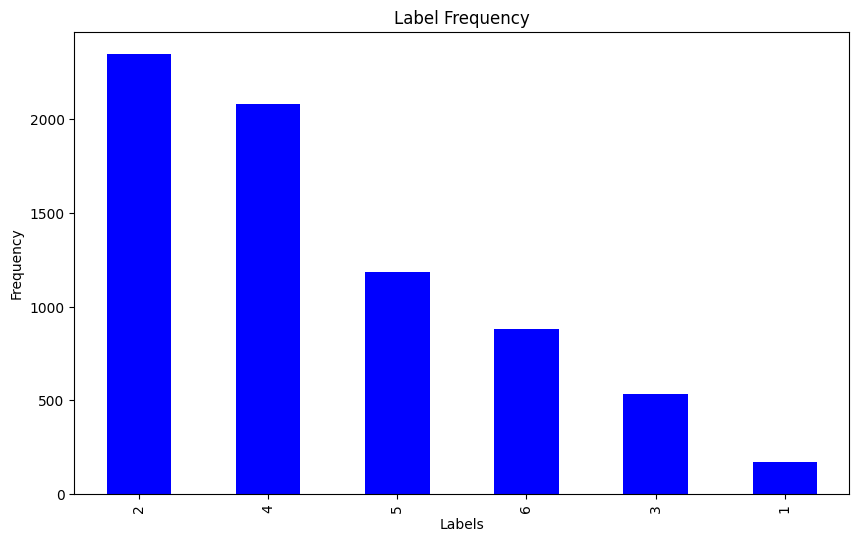

In [ ]:
labels_column = 'label'

# Count the frequency of each label
label_counts = df[labels_column].value_counts()

# Plot the frequency of labels
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='blue',sort_columns=True)
plt.title('Label Frequency')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# x_train = df['filename'].values
# y_train = df['label'].values

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

csv_file_path = '/content/extracted_images/vehicle_damage_detection/archive/train/train/train.csv'
df = pd.read_csv(csv_file_path)

image_column = 'filename'
label_column = 'label'

file_paths = df[image_column].values
labels = df[label_column].values

y_train = labels-1

# Split the data into training and validation sets
x_train_paths, x_val_paths, y_train_final, y_val = train_test_split(file_paths, y_train, test_size=0.2, random_state=42)

# Define a function to load and preprocess images
def load_and_preprocess_images(file_paths):
    images = []
    for path in file_paths:
        image = cv2.imread(os.path.join('/content/extracted_images/vehicle_damage_detection/archive/train/train/images', path))
        # Perform any necessary preprocessing on the image
        # For example, you might want to resize the image to a fixed size
        image = cv2.resize(image, (desired_width, desired_height))
        images.append(image)
    return np.array(images)


# Define the desired width and height of the images
desired_width = 244
desired_height = 244

# Load and preprocess images for training and validation sets
x_train_images = load_and_preprocess_images(x_train_paths)
x_val_images = load_and_preprocess_images(x_val_paths)



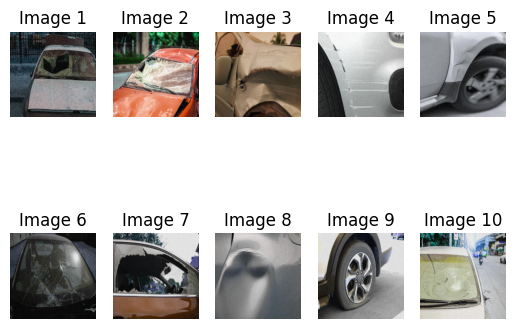

In [ ]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(15, 6))
for i in range(0, 10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_images[i])
    plt.title(f'Image {i + 1}')
    plt.axis('off')

plt.show()

In [ ]:
len(x_train_paths), len(x_val_paths), len(y_train_final), len(y_val)
# import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_images, y_train_final))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_images, y_val))

len(train_dataset),len(val_dataset)


(5760, 1440)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(244, 244),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Assuming you have your original dataset named train_dataset
# Also assuming that x_train_images and y_train_labels are loaded from your dataset

# Define the preprocessing sequences
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(244, 244),
    layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Apply the preprocessing to the original dataset
preprocessed_original_dataset = train_dataset.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
preprocessed_original_dataset = preprocessed_original_dataset.map(lambda x, y: (tf.cast(data_augmentation(x, training=False), tf.uint8), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Combine the original and augmented datasets
combined_dataset = train_dataset.concatenate(preprocessed_original_dataset)




In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_images, y_train_final))

# Get the number of elements in the dataset
num_elements = train_dataset.cardinality().numpy()

# Choose 10 random indices
random_indices = np.random.choice(num_elements, size=10, replace=False)

random_images = []
random_labels = []

for i, (image, label) in enumerate(train_dataset.as_numpy_iterator()):
    if i in random_indices:
        random_images.append(image)
        random_labels.append(label)




Exception ignored in: <function Executor.__del__ at 0x7ae115791b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


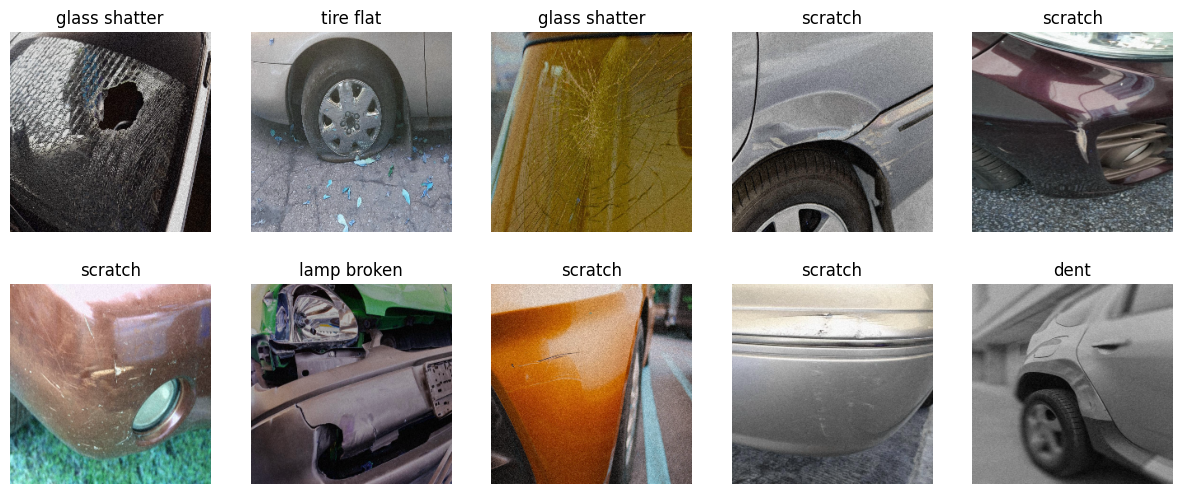

In [ ]:
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(random_images[i])
    plt.title(f'{Label_in_eng[random_labels[i]]}')
    plt.axis('off')

plt.show()

In [ ]:
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    # Add more augmentation functions as needed
    return image, label

# Apply data augmentation to the dataset
train_dataset = train_dataset.concatenate(train_dataset.map(augment_data))

len(train_dataset)

11520

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import models, layers


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import ResNet50

# Define your constants
IMAGE_SIZE = (244, 244)  # Adjust this based on your actual image size
CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 32  # Adjust this based on your needs

# Assuming you have your datasets defined as train_dataset and val_dataset

# Use TPU strategy if applicable
# tpu_strategy = tf.distribute.TPUStrategy(resolver)

train_dataset = train_dataset.shuffle(buffer_size=10000)

# Optionally, batch the dataset
batch_size = 32
train_dataset_batched = train_dataset.batch(batch_size)
val_dataset_batched = val_dataset.batch(batch_size)
len(train_dataset_batched)

with tpu_strategy.scope():
    input_shape = (244, 244, CHANNELS)

    # Use the ResNet50 model as a base model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Make the layers of the base model non-trainable
    for layer in base_model.layers:
        layer.trainable = False

    # Build your own model on top of ResNet50
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(6, activation=None))  # Adjust the number of output units based on your problem
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Print model summary for inspection
model.summary()

# Assuming you have train_dataset and val_dataset defined
history = model.fit(
    train_dataset_batched,
    epochs=15,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_dataset_batched
)


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 256)               524544    
                                                                 
 dense_15 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 24,113,798
Trainable params: 526,086
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/20
360/360 [==============================] - 44s 66ms/step - loss: 0.7355 - accuracy: 0.7199

In [ ]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 256)               524544    
                                                                 
 dense_15 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 24,113,798
Trainable params: 526,086
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
model.evaluate(val_dataset_batched)

45/45 [==============================] - 3s 30ms/step - loss: 0.1721 - accuracy: 0.9521


[0.17209604382514954, 0.9520833492279053]

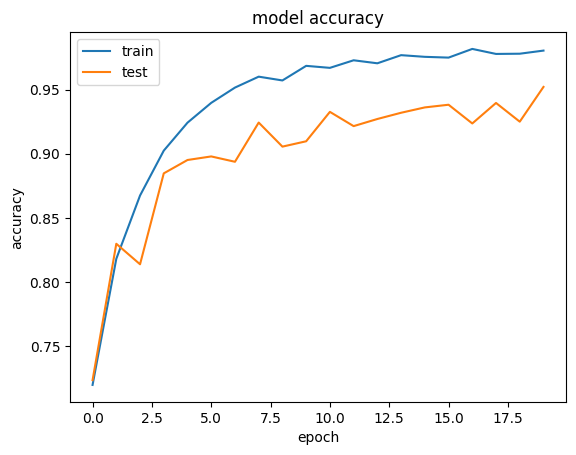

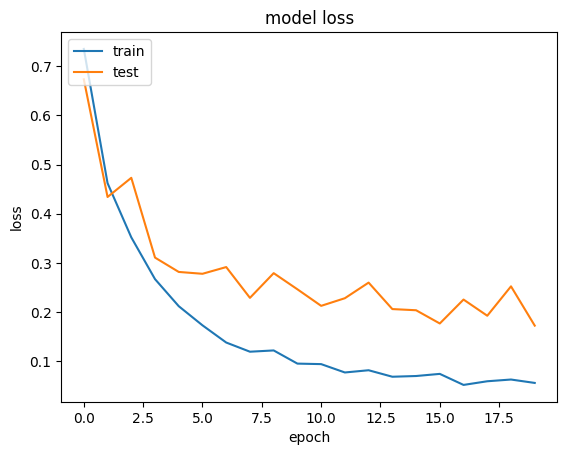

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
pred=tf.nn.softmax(model.predict(val_dataset_batched))

45/45 [==============================] - 12s 200ms/step


In [ ]:
pred=np.argmax(pred.numpy(),axis=1)

In [ ]:
pred

array([1, 4, 3, ..., 3, 1, 1])

In [ ]:
val_ = val_dataset_batched.map(lambda x, y: y)
val_list = np.concatenate(list(val_.as_numpy_iterator()))

Exception ignored in: <function Executor.__del__ at 0x7ae115791b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


In [ ]:
val_list

array([1, 4, 3, ..., 3, 1, 1])

In [ ]:
tf.math.confusion_matrix(val_list,pred)

<tf.Tensor: shape=(6, 6), dtype=int32, numpy=
array([[ 23,   2,   0,   2,   0,   0],
       [  1, 449,   0,  18,   1,   4],
       [  0,   1, 112,   1,   0,   0],
       [  0,  13,   1, 384,   0,   5],
       [  0,   1,   0,   2, 241,   0],
       [  0,   9,   0,   8,   0, 162]], dtype=int32)>

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_val is the true labels (ground truth)
# y_true = np.argmax(y_val, axis=1)  # Convert one-hot encoded labels to class labels

# Assuming y_pred contains the predicted probabilities
 # Convert predicted probabilities to class labels

# Calculate confusion matrix
cm = confusion_matrix(val_list, pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[ 23   2   0   2   0   0]
 [  1 449   0  18   1   4]
 [  0   1 112   1   0   0]
 [  0  13   1 384   0   5]
 [  0   1   0   2 241   0]
 [  0   9   0   8   0 162]]


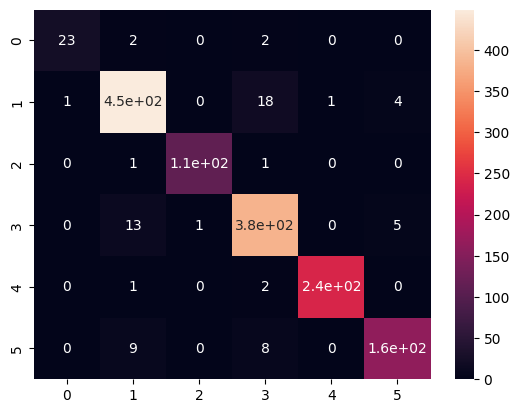

In [ ]:
import seaborn as sns
sns.heatmap(cm,annot=True);

In [ ]:
!pip install ptflops

In [ ]:
total_parameters = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
total_macs = 0
total_flops = 0

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        total_macs += 2 * layer.filters * layer.kernel_size[0] * layer.kernel_size[1] * layer.input_shape[-1] * layer.output_shape[-1] * layer.output_shape[1] * layer.output_shape[2] / layer.strides[0] / layer.strides[1]
        total_flops += total_macs * 2  # Assuming each MAC operation involves 2 FLOPs
    elif isinstance(layer, tf.keras.layers.Dense):
        total_macs += 2 * layer.input_shape[-1] * layer.units
        total_flops += total_macs * 2  # Assuming each MAC operation involves 2 FLOPs

# Calculate GMAC (1 GMAC = 10^9 MAC)
gmac = total_macs / 1e9

# Calculate GFLOPS (1 GFLOP = 10^9 FLOPs)
gflops = total_flops / 1e9

print(f'Total Parameters: {total_parameters}')
print(f'GMAC Operations: {gmac}')
print(f'GFLOPs: {gflops}')

Total Parameters: 526086
GMAC Operations: 0.001051648
GFLOPs: 0.004200448


In [ ]:
model.save('/content/extracted_images/saved_models/my_model')

In [ ]:
test_df = pd.read_csv('/content/extracted_images/vehicle_damage_detection/archive/test/test/test.csv')

In [ ]:
test_df

,image_id,filename
0,7201,7201.jpg
1,7202,7202.jpg
2,7203,7203.jpg
3,7204,7204.jpg
4,7205,7205.jpg
...,...,...
4795,11996,11996.jpg
4796,11997,11997.jpg
4797,11998,11998.jpg
4798,11999,11999.jpg


In [ ]:
image_column = 'filename'

file_paths = test_df[image_column].values

x_test_paths = file_paths

# Define a function to load and preprocess images
def load_and_preprocess_images(file_paths):
    images = []
    for path in file_paths:
        image = cv2.imread(os.path.join('/content/extracted_images/vehicle_damage_detection/archive/test/test/images', path))
        image = cv2.resize(image, (desired_width, desired_height))
        images.append(image)
    return np.array(images)


# Define the desired width and height of the images
desired_width = 244
desired_height = 244

# Load and preprocess images for training and validation sets
x_test_images = load_and_preprocess_images(x_test_paths)



1/1 [==============================] - 1s 610ms/step


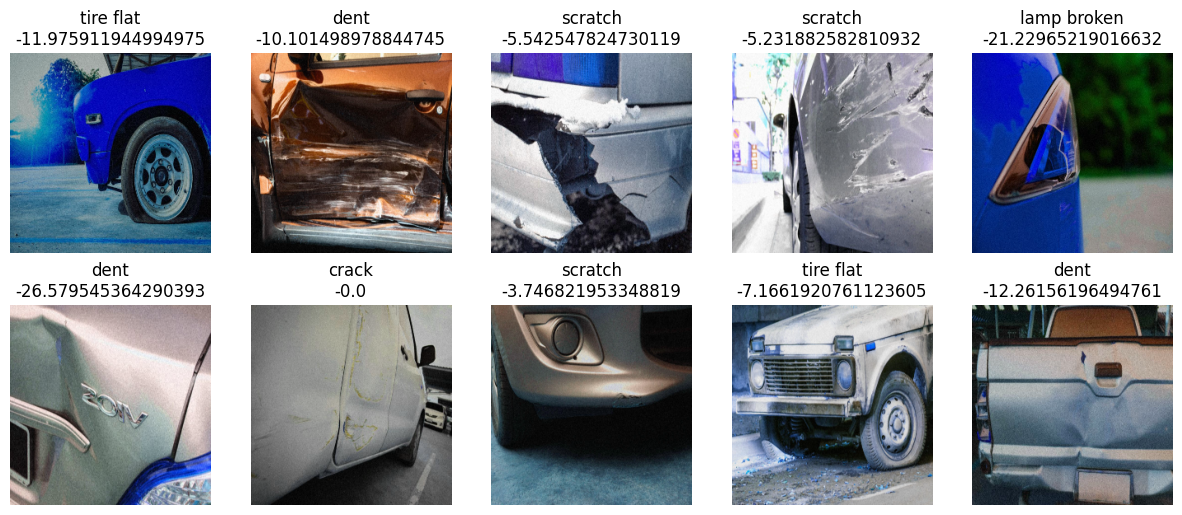

In [ ]:
random_list = np.random.randint(0, 4001, size=10)
plt.figure(figsize=(15, 6))
level = 0
for i in random_list:
    plt.subplot(2, 5, level + 1)
    level = level + 1
    plt.imshow(x_test_images[i])
    x = model.predict(np.expand_dims(x_test_images[i], axis=0))
    predicted_class_index = np.argmax(x)
    predicted_label = Label_in_eng[predicted_class_index]
    confidence = (predicted_class_index*100)/x.sum()
    plt.title(f'{predicted_label}\n{confidence}')
    plt.axis('off')

plt.show()


In [ ]:
import numpy as np

# Assuming x_test_images[0] is the image for which you want to calculate confidence

# Get the logits (raw scores) for each class
logits = model.predict(np.expand_dims(x_test_images[0], axis=0))

# Use softmax to get probabilities
probabilities = tf.nn.softmax(logits)
predicted_class_index = np.argmax(probabilities)
predicted_label = Label_in_eng[predicted_class_index]

# Calculate confidence as a percentage
confidence = probabilities[0, predicted_class_index] * 100

print(probabilities, predicted_class_index, predicted_label, confidence)

1/1 [==============================] - 1s 1s/step


InvalidArgumentError: slice index 1 of dimension 0 out of bounds. [Op:Mul]